# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [76]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import os
from scipy.stats import linregress
from datetime import datetime

# Import the OpenWeatherMap API key
from api_keys import weather_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

### Generate the Cities List by Using the `citipy` Library

In [46]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 605


In [47]:
# For convenience during development and troubleshooting, cut down the number of cities
MAX_CITIES = 99999
if len(cities) > MAX_CITIES:
    cities = cities[0:MAX_CITIES]
    print(f"Number of cities in the reduced list: {len(cities)}")

---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the starter code

In [48]:
# Set the API base URL
url = f"http://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units=metric"

# Define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Date we're getting date -- used below in charts
date_str = datetime.today().strftime('%Y-%m-%d')

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):

    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    city_url = f"{url}&q={city}" #!!! Units

    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Run an API request for each of the cities.
    # The WeatherPy starter notebook has a simple exception handler treating ANY exception from the request
    # and parsing of city data as though it means the city wasn't found. This is a terrible pattern to teach
    # people. Exceptions happen for lots of reasons, in this case usually because we aren't digging into the
    # JSON structure right. The correct way to detect a "city not found" error is by looking at the response
    # code: 404 means not found.
    response = requests.get(city_url)
    city_weather = response.json()
    if response.ok:
        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]

        city_dict = {
                "City": city,
                "Lat": city_lat,
                "Lng": city_lng,
                "Max Temp": city_max_temp,
                "Humidity": city_humidity,
                "Cloudiness": city_clouds,
                "Wind Speed": city_wind,
                "Country": city_country,
                "Date": city_date}
        #print(city_dict)

        city_data.append(city_dict)
    else:
        # There was a problem with the request. Perhaps the city was not found...
        # Print the message and keep going.
        print(f"Error #{response.status_code} getting city \"{city}\": \"{city_weather['message']}\"")

    # pause to avoid rate limiting
    time.sleep(1)

# Indicate that Data Loading is complete
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | papatowai
Processing Record 2 of Set 1 | alo
Processing Record 3 of Set 1 | olinda
Processing Record 4 of Set 1 | hamilton
Processing Record 5 of Set 1 | port-aux-francais
Processing Record 6 of Set 1 | rongelap
Processing Record 7 of Set 1 | fortaleza
Processing Record 8 of Set 1 | hithadhoo
Processing Record 9 of Set 1 | bethel
Processing Record 10 of Set 1 | grytviken
Processing Record 11 of Set 1 | waitangi
Processing Record 12 of Set 1 | bredasdorp
Processing Record 13 of Set 1 | mpongwe
Processing Record 14 of Set 1 | badger
Processing Record 15 of Set 1 | turis
Processing Record 16 of Set 1 | constantia
Processing Record 17 of Set 1 | ilulissat
Processing Record 18 of Set 1 | acarau
Processing Record 19 of Set 1 | qaqortoq
Processing Record 20 of Set 1 | taiohae
Error #404 getting city "taiohae": "city not found"
Processing Record 21 of Set 1 | viedma
Processing Record 22 of Set 1 | adamst

In [58]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Show Record Count
city_data_df.count()

City          584
Lat           584
Lng           584
Max Temp      584
Humidity      584
Cloudiness    584
Wind Speed    584
Country       584
Date          584
dtype: int64

In [59]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,papatowai,-46.5619,169.4708,8.03,93,100,1.32,NZ,1722197007
1,alo,6.5486,4.2686,24.70,87,100,5.30,NG,1722197008
2,olinda,-8.0089,-34.8553,26.85,74,40,5.66,BR,1722197010
3,hamilton,39.1834,-84.5333,25.80,89,75,6.17,US,1722197011
4,port-aux-francais,-49.3500,70.2167,0.48,65,97,14.82,TF,1722197012


In [60]:
# Export the City_Data into a csv

# Make the output directory if it doesn't already exist, since you can check empty directories into Git
if not os.path.exists("output_data"):
    print("Making output directory")
    os.makedirs("output_data")
city_data_df.to_csv("output_data/cities.csv", index_label="City_ID")

In [62]:
# Read saved data
city_data_df = pd.read_csv("output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,papatowai,-46.5619,169.4708,8.03,93,100,1.32,NZ,1722197007
1,alo,6.5486,4.2686,24.70,87,100,5.30,NG,1722197008
2,olinda,-8.0089,-34.8553,26.85,74,40,5.66,BR,1722197010
3,hamilton,39.1834,-84.5333,25.80,89,75,6.17,US,1722197011
4,port-aux-francais,-49.3500,70.2167,0.48,65,97,14.82,TF,1722197012
...,...,...,...,...,...,...,...,...,...
579,bairnsdale,-37.8333,147.6167,5.03,88,92,3.57,AU,1722197725
580,kroya,-7.6331,109.2461,24.13,92,18,2.28,ID,1722197726
581,charters towers,-20.1000,146.2667,12.90,76,56,6.53,AU,1722197727


### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

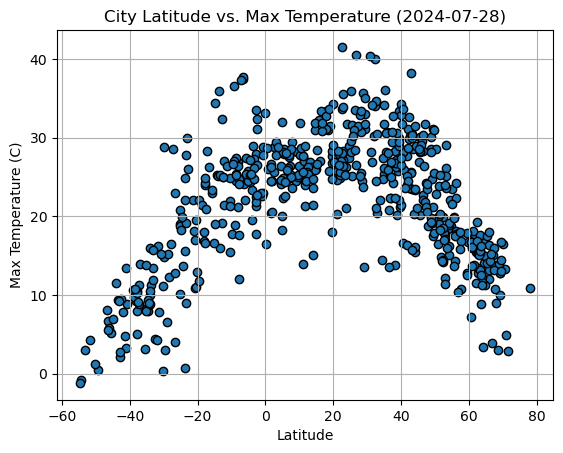

In [82]:
# Build scatter plot for latitude vs. temperature
plt.scatter(city_data_df["Lat"], city_data_df["Max Temp"], edgecolors="black")

# Incorporate the other graph properties
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (C)")
plt.title(f"City Latitude vs. Max Temperature ({date_str})")
plt.grid()

# Save the figure
plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()

#### Latitude Vs. Humidity

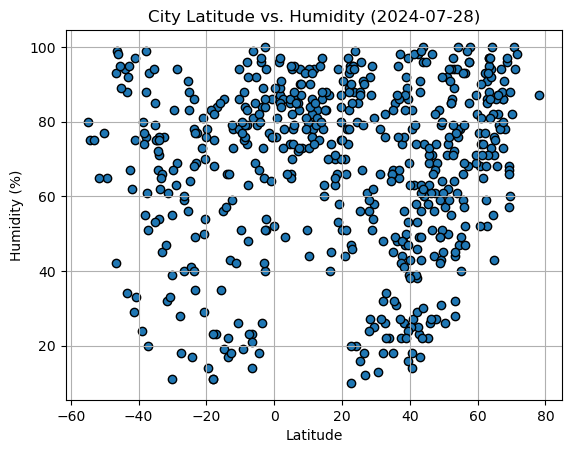

In [80]:
# Build the scatter plots for latitude vs. humidity
plt.scatter(city_data_df["Lat"], city_data_df["Humidity"], edgecolors="black")

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Humidity ({date_str})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()

# Save the figure
plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()

#### Latitude Vs. Cloudiness

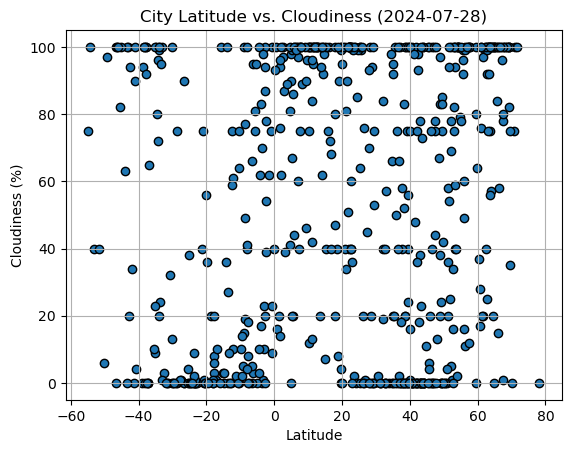

In [81]:
# Build the scatter plots for latitude vs. cloudiness
plt.scatter(city_data_df["Lat"], city_data_df["Cloudiness"], edgecolors="black")

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Cloudiness ({date_str})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid()

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

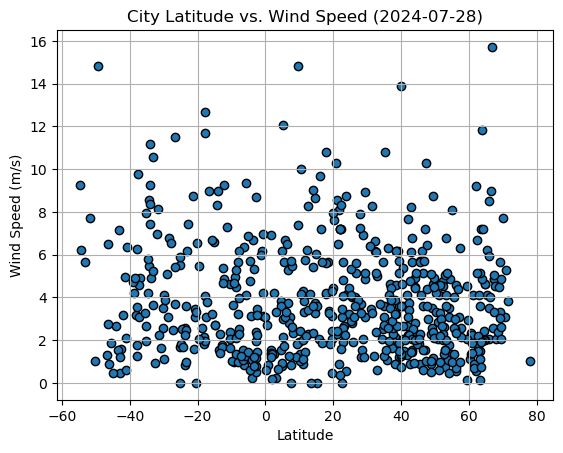

In [83]:
# Build the scatter plots for latitude vs. wind speed
plt.scatter(city_data_df["Lat"], city_data_df["Wind Speed"], edgecolors="black")

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Wind Speed ({date_str})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (m/s)")
plt.grid()

# Save the figure
plt.savefig("output_data/Fig4.png")

# Show plot
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


In [94]:
# Define a function to create Linear Regression plots
def PlotRegressionWithLatitude(df, column_name):
    x_values = df["Lat"]
    y_values = df[column_name]
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    
    plt.scatter(x_values, y_values)
    plt.title(f"Latitude vs. {column_name}")
    plt.xlabel("Latitude")
    plt.ylabel(column_name)
    plt.plot(x_values, regress_values, "r-")

In [84]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
northern_hemi_df = city_data_df.loc[city_data_df["Lat"] >= 0]

# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
1,alo,6.5486,4.2686,24.70,87,100,5.30,NG,1722197008
3,hamilton,39.1834,-84.5333,25.80,89,75,6.17,US,1722197011
5,rongelap,11.1635,166.8941,27.69,76,84,4.31,MH,1722197013
8,bethel,41.3712,-73.4140,28.13,63,0,3.60,US,1722197017
13,badger,64.8000,-147.5333,14.95,71,100,4.63,US,1722197023


In [86]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df.loc[city_data_df["Lat"] < 0]

# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,papatowai,-46.5619,169.4708,8.03,93,100,1.32,NZ,1722197007
2,olinda,-8.0089,-34.8553,26.85,74,40,5.66,BR,1722197010
4,port-aux-francais,-49.3500,70.2167,0.48,65,97,14.82,TF,1722197012
6,fortaleza,-3.7227,-38.5247,28.93,84,0,6.69,BR,1722197014
7,hithadhoo,-0.6000,73.0833,28.84,76,100,4.19,MV,1722197016


###  Temperature vs. Latitude Linear Regression Plot

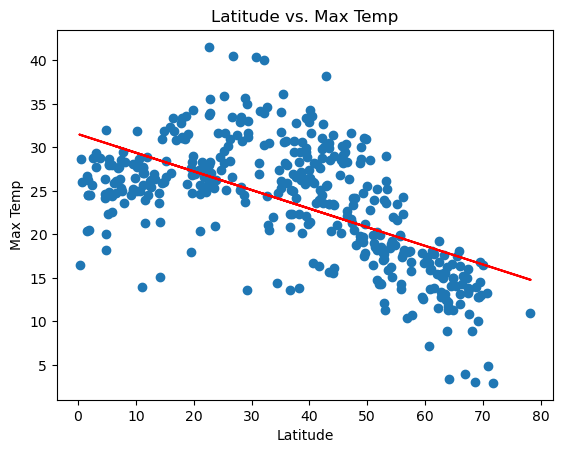

In [96]:
# Linear regression on Northern Hemisphere
PlotRegressionWithLatitude(northern_hemi_df, "Max Temp")

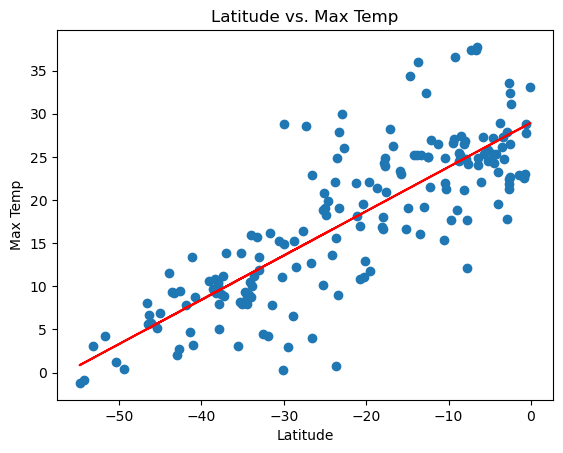

In [97]:
# Linear regression on Southern Hemisphere
PlotRegressionWithLatitude(southern_hemi_df, "Max Temp")

**Discussion about the linear relationship:** There is clearly a strong correlation: the futher you get from the equator, the lower the max temperature is.

### Humidity vs. Latitude Linear Regression Plot

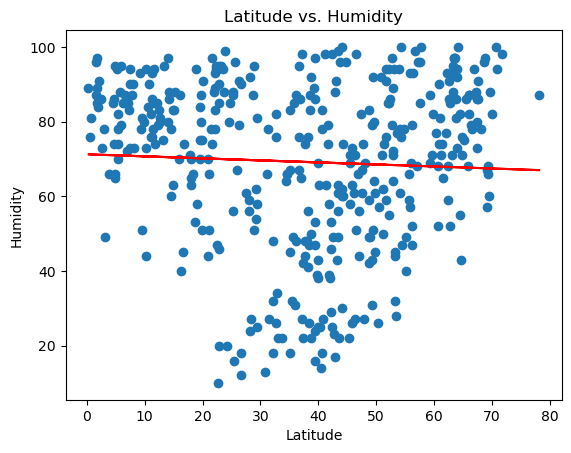

In [98]:
# Northern Hemisphere
PlotRegressionWithLatitude(northern_hemi_df, "Humidity")

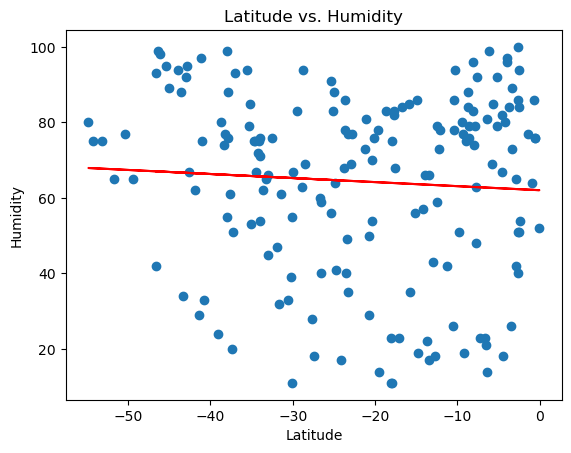

In [99]:
# Southern Hemisphere
PlotRegressionWithLatitude(southern_hemi_df, "Humidity")

**Discussion about the linear relationship:** There may be a small correlation, with lower humidity as you get further from the equator. But I wouldn't confidently say the correlation is proven.

### Cloudiness vs. Latitude Linear Regression Plot

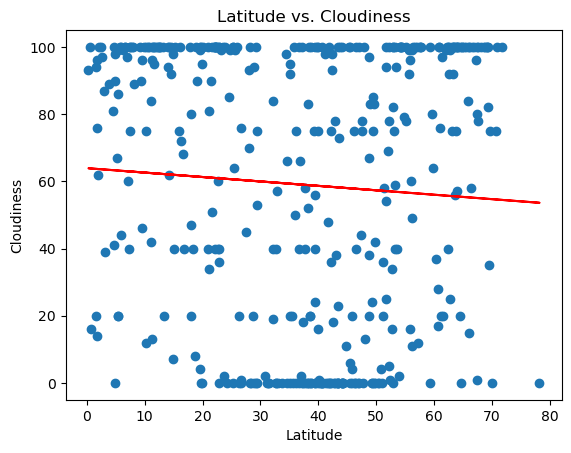

In [100]:
# Northern Hemisphere
PlotRegressionWithLatitude(northern_hemi_df, "Cloudiness")

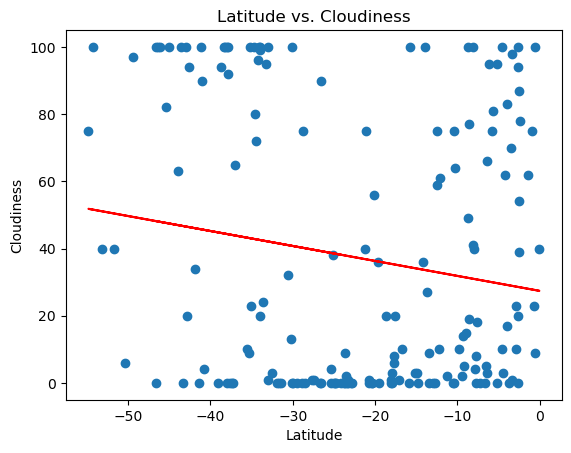

In [101]:
# Southern Hemisphere
PlotRegressionWithLatitude(southern_hemi_df, "Cloudiness")

**Discussion about the linear relationship:** There seems to be a correlation, with latitudes further from the equator having lower humidity. This is stronger for the Southern hemisphere, while the Northern hemisphere's trend is less clear.

### Wind Speed vs. Latitude Linear Regression Plot

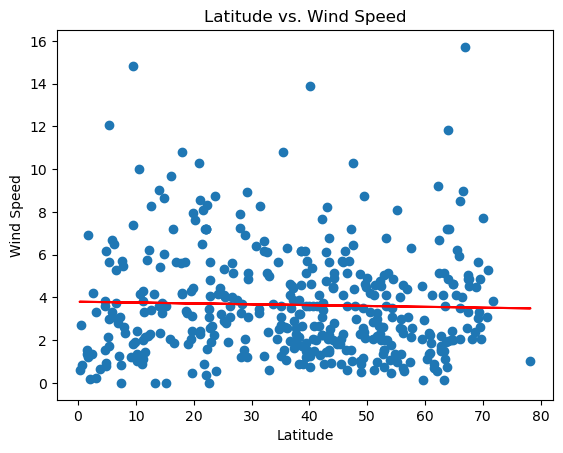

In [102]:
# Northern Hemisphere
PlotRegressionWithLatitude(northern_hemi_df, "Wind Speed")

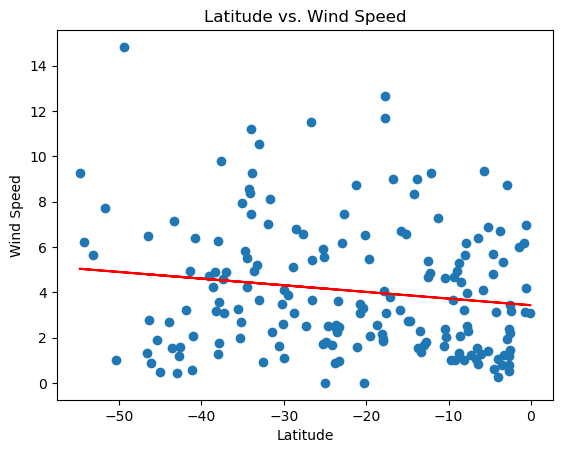

In [103]:
# Southern Hemisphere
PlotRegressionWithLatitude(southern_hemi_df, "Wind Speed")

**Discussion about the linear relationship:** There may be a small correlation in the Sourthern hemisphere, with lower wind speeds as you get further from the equator. But there is clearly little or no correlation in the Northern hemisphere.